In [1]:
import os
import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras

from sklearn import metrics
from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

2024-07-02 03:39:19.666700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 03:39:19.666804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 03:39:19.799783: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
0.4.26


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? False


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_TFREC = "/kaggle/input/leap-train-tfrecords"

In [5]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    return tf.io.parse_single_example(example_proto, feature_description)['x'], tf.io.parse_single_example(example_proto, feature_description)['targets']

In [7]:
train_files = [os.path.join(DATA_TFREC, f"train_{i:03d}.tfrec") for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_100.tfrec")]

In [8]:
BATCH_SIZE = 2048

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(lambda file: tf.data.TFRecordDataset(file).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE),
                num_parallel_calls=tf.data.AUTOTUNE, cycle_length=10, block_length=1000, deterministic=True)
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [9]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(20 if is_interactive() else 1000))

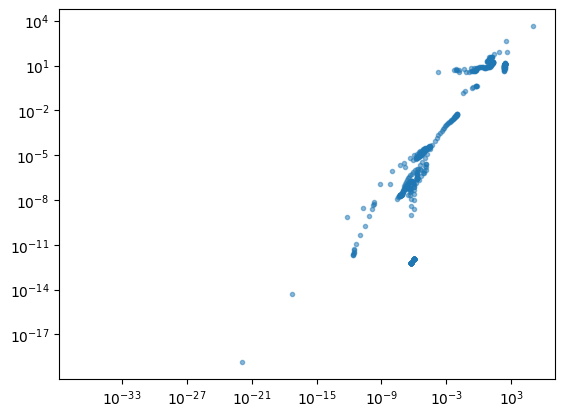

In [10]:
# Convert tensors to numpy arrays and then squeeze
mean_x = norm_x.mean.numpy().squeeze()
variance_x = (norm_x.variance.numpy() ** 0.5).squeeze()

plt.scatter(mean_x, variance_x, marker=".", alpha=0.5)
plt.xscale('log')
plt.yscale('log')

In [11]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(20 if is_interactive() else 1000))

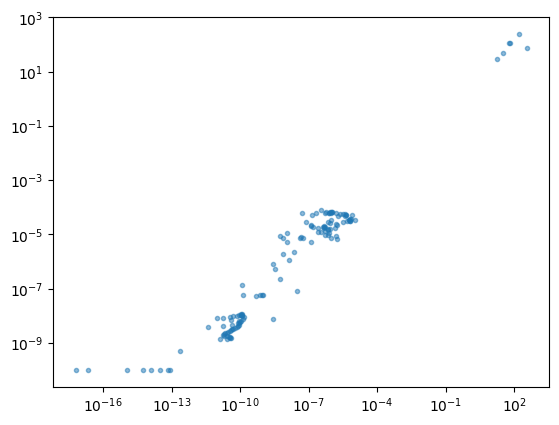

In [12]:
mean_y = norm_y.mean.numpy()
stdd_y = np.maximum(1e-10, norm_y.variance.numpy() ** 0.5)

plt.scatter(mean_y.squeeze(), stdd_y.squeeze(), marker=".", alpha=0.5)
plt.xscale('log')
plt.yscale('log')

In [13]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)

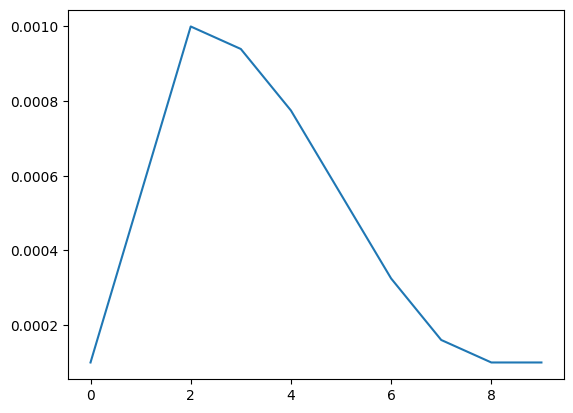

In [14]:
epochs = 10
learning_rate = 1e-3

epochs_warmup = 2
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-4, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)])

In [15]:
model = keras.Sequential([
    keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(len(TARGETS))
])
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr_scheduler))
model.build(tuple(ds_train.element_spec[0].shape))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 556)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 368)            │       188,784 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,283,952 (4.90 MB)

 Trainable params: 1,283,952 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

In [17]:
history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[keras.callbacks.ModelCheckpoint(filepath='model.keras')]
)

Epoch 1/10


I0000 00:00:1719891725.582236      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719891725.599109      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719891904.071342      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1719891904.662155      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4883/4883 - 186s - 38ms/step - loss: 0.4488 - val_loss: 0.3680
Epoch 2/10


W0000 00:00:1719891908.573992      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4883/4883 - 205s - 42ms/step - loss: 0.3881 - val_loss: 0.3517
Epoch 3/10
4883/4883 - 192s - 39ms/step - loss: 0.3717 - val_loss: 0.3382
Epoch 4/10
4883/4883 - 199s - 41ms/step - loss: 0.3588 - val_loss: 0.3311
Epoch 5/10
4883/4883 - 208s - 43ms/step - loss: 0.3478 - val_loss: 0.3197
Epoch 6/10
4883/4883 - 204s - 42ms/step - loss: 0.3380 - val_loss: 0.3080
Epoch 7/10
4883/4883 - 196s - 40ms/step - loss: 0.3307 - val_loss: 0.3036
Epoch 8/10
4883/4883 - 189s - 39ms/step - loss: 0.3262 - val_loss: 0.3013
Epoch 9/10
4883/4883 - 196s - 40ms/step - loss: 0.3245 - val_loss: 0.3007
Epoch 10/10
4883/4883 - 196s - 40ms/step - loss: 0.3236 - val_loss: 0.2989


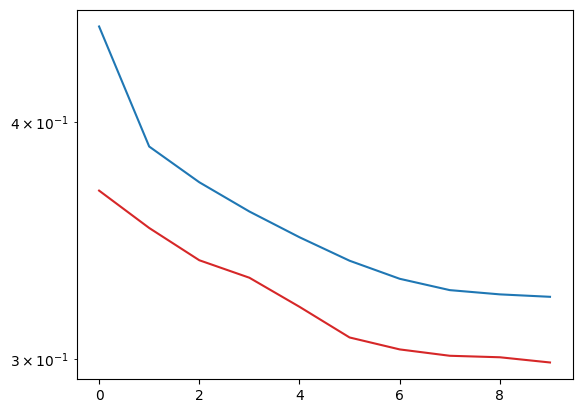

In [18]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.yscale('log')

In [19]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

     10/Unknown 1s 21ms/step

W0000 00:00:1719893697.556115      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


W0000 00:00:1719893699.023542      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


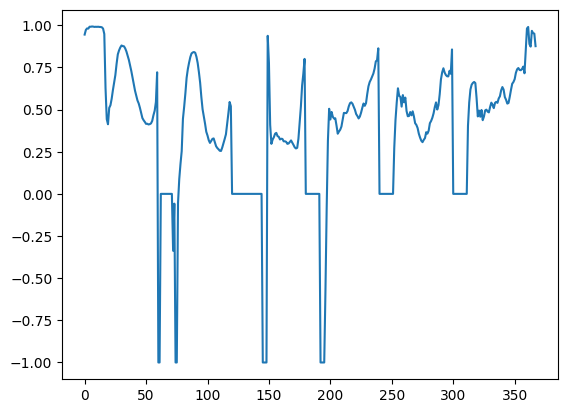

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

In [21]:
mask = scores_valid <= 1e-3
print(f"Number of under-performing targets: {sum(mask)}")

Number of under-performing targets: 88


In [22]:
print(f"Clipped score: {scores_valid.clip(0, 1).mean()}")

Clipped score: 0.4312805937527462


In [23]:
del y_valid, p_valid
gc.collect()

16677

In [24]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"))

In [25]:
df_test = (
    pl.scan_csv(os.path.join(DATA, "test.csv"))
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

In [26]:
p_test = model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y + mean_y
p_test = np.array(p_test)
p_test[:, mask] = mean_y[:, mask]

df_p_test = pd.DataFrame(p_test, columns=TARGETS)

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


W0000 00:00:1719893742.832882      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [27]:
for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200

p_test = df_p_test.values

In [28]:
submission = sample.to_pandas()
submission[TARGETS] = submission[TARGETS] * p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")